## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [2]:
file_name="~/data/data_000637.txt"

N = 10000  #arbitrary number of rows to read
data=pd.read_csv(file_name, nrows = N)

df = pd.DataFrame(data)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
9995,1,0,61,3869200267,696,11
9996,1,0,60,3869200267,701,5
9997,1,0,59,3869200267,707,23
9998,1,0,63,3869200267,706,15


2\. Find out the number of BX in a ORBIT (the value 'x').

In [3]:
x = df['BX_COUNTER'].max() +1    #find maximum value of BX_COUNTER before reset (add 1 because counting starts from 0)
x

3564

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [4]:
#both ex 3. and 4:

df['TOTAL_TIME'] = (df['ORBIT_CNT']*x + df['BX_COUNTER'])*25 + (25/30)*df['TDC_MEAS']   #time in ns
time_rate = (df.loc[N-1,'TOTAL_TIME'] - df.loc[0,'TOTAL_TIME'])/N      #mean acquirence time per iteration (ns)



print('for an average 1 300 000 data acquired:', time_rate*1300000 * pow(10,-9),'s')

for an average 1 300 000 data acquired: 1.15310833625 s


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [5]:
df['HEAD'] = np.random.randint(0,2,N)

6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [6]:
df2 = df[df['HEAD'] == 1]
df2

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TOTAL_TIME
0,1,0,123,3869200167,2374,26,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
7,1,0,139,3869200167,2776,0,3.447457e+14
8,1,0,62,3869200167,2774,21,3.447457e+14
...,...,...,...,...,...,...,...
9994,1,0,57,3869200267,696,27,3.447457e+14
9995,1,0,61,3869200267,696,11,3.447457e+14
9996,1,0,60,3869200267,701,5,3.447457e+14
9998,1,0,63,3869200267,706,15,3.447457e+14


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

Text(0.5, 1.0, 'FPAG occupancy (counts vs tdc channel):')

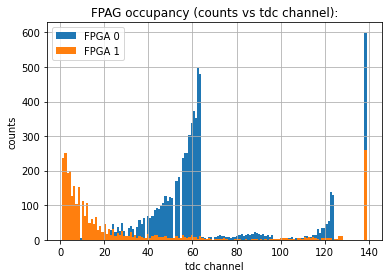

In [16]:
FPGA0 = df[df['FPGA'] == 0]
FPGA1 = df[df['FPGA'] == 1]

FPGA0['TDC_CHANNEL'].hist(bins = 140, label = 'FPGA 0')
FPGA1['TDC_CHANNEL'].hist(bins = 140, label = 'FPGA 1')
plt.legend()
plt.xlabel('tdc channel')
plt.ylabel('counts')
plt.title('FPAG occupancy (counts vs tdc channel):')

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [21]:
x = df.groupby('TDC_CHANNEL').size().rank(ascending=False).sort_values()   #returns an indexed series with most used index as first elements
print('The most noisy channels are (channel/rank):\n' , x[:3])  #print top three

The most noisy channels are (channel/rank):
 TDC_CHANNEL
139    1.0
63     2.0
64     3.0
dtype: float64


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [31]:
df9 = df.groupby('ORBIT_CNT')
print('the number of unique orbits is:', len(df9))
print('of those, the ones with at least one count from TDC_CHANNEL 139 are:', len(df[df['TDC_CHANNEL'] == 139].groupby('ORBIT_CNT')))

#Every unique orbit has at least one measurement made w/ ch139


the number of unique orbits is: 101
of those, the ones with at least one count from TDC_CHANNEL 139 are: 101
